In [63]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. OBTENCIÓN Y PREPARACIÓN DE DATOS
# ==========================================
ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2025-11-01')

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Ingeniería de Variables (Features)
data['Returns'] = data['Close'].pct_change()
data['EMA30'] = data['Close'].ewm(span=30, adjust=False).mean()
data['ROC_10'] = data['Close'].pct_change(periods=10)
data['Daily_Range'] = (data['High'] - data['Low']) / data['Close']
data['Volatilidad_10d'] = data['Returns'].rolling(window=10).std()
data['Vol_Relativo'] = data['Volume'] / data['Volume'].rolling(window=30).mean()

data['Money_Flow'] = data['Returns'] * data['Volume']
data['MFI_5'] = data['Money_Flow'].rolling(window=5).mean()

# 2. Volume Force (¿El volumen está empujando el precio?)
data['Vol_Force'] = data['Returns'] * (data['Volume'] / data['Volume'].rolling(window=20).mean())

# VWAP = suma(Precio * Volumen) / suma(Volumen)
data['Typical_Price'] = (data['High'] + data['Low'] + data['Close']) / 3
data['Price_Vol'] = data['Typical_Price'] * data['Volume']

# Calculamos el VWAP acumulado
data['VWAP'] = data['Price_Vol'].cumsum() / data['Volume'].cumsum()

data['Dist_VWAP'] = (data['Close'] - data['VWAP']) / data['VWAP']

# Filtro que usaremos después (lo mantenemos fuera de las features de entrenamiento)
data['Above_EMA30'] = (data['Close'] > data['EMA30']).astype(int)

# Target: Subida > 0.3% mañana
data['Target'] = (data['Close'].shift(-1) > data['Close'] * 1.003).astype(int)
data.dropna(inplace=True)

# 2. SELECCIÓN DE CARACTERÍSTICAS
# Nota: No incluimos Above_EMA30 aquí para usarlo solo como filtro humano/lógico final
features = ['Returns', 'ROC_10', 'Daily_Range', 'Volatilidad_10d', 'Vol_Relativo', 'Dist_VWAP', 'MFI_5', 'Vol_Force']
X = data[features]
y = data['Target']

split = int(len(data) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 3. OPTUNA
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Lista para almacenar los resultados de cada intento
resultados = []

def objective(trial):
    # Definimos el diccionario de métricas DENTRO de la función para evitar el NameError
    scoring_metrics = {
        'accuracy': 'accuracy',
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }
    
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost', 'GradientBoosting'])
    
    if classifier_name == 'RandomForest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'class_weight': 'balanced'
        }
        model = RandomForestClassifier(**params, random_state=42)
    elif classifier_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'scale_pos_weight': 3 
        }
        model = XGBClassifier(**params, random_state=42, eval_metric='logloss')
    else:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
        }
        model = GradientBoostingClassifier(**params, random_state=42)

    # Cross Validate
    cv_results = cross_validate(model, X_train, y_train, cv=3, scoring=scoring_metrics)
    
    m_acc = cv_results['test_accuracy'].mean()
    m_rec = cv_results['test_recall'].mean()
    m_f1 = cv_results['test_f1'].mean()
    
    resultados.append({
        'Modelo': classifier_name,
        'Accuracy': m_acc,
        'Recall': m_rec,
        'F1-Score': m_f1
    })
    
    return m_f1 # Optimizamos buscando el mejor equilibrio (F1)

# 2. Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# 3. Tabla Final para la diapositiva
df_res = pd.DataFrame(resultados)
tabla_final = df_res.sort_values('F1-Score', ascending=False).drop_duplicates('Modelo').reset_index(drop=True)

print("\n--- COMPARATIVA TÉCNICA (PARA LA PRESENTACIÓN) ---")
print(tabla_final.to_string(index=False))

# 4. Re-entrenar el mejor modelo (best_model)
mejor_tipo = study.best_params['classifier']
params_finales = {k: v for k, v in study.best_params.items() if k != 'classifier'}

if mejor_tipo == 'RandomForest':
    best_model = RandomForestClassifier(**params_finales, random_state=42)
elif mejor_tipo == 'XGBoost':
    best_model = XGBClassifier(**params_finales, random_state=42)
else:
    best_model = GradientBoostingClassifier(**params_finales, random_state=42)

best_model.fit(X_train, y_train)

# ==========================================
# 4. LÓGICA DE FILTRADO DINÁMICO
# ==========================================
# Usamos probabilidades para tener control sobre la agresividad del modelo
probs = best_model.predict_proba(X_test)[:, 1]

y_pred_filtered = []
for i in range(len(X_test)):
    
    # Recuperamos el valor de Above_EMA30 usando el índice original
    idx = X_test.index[i]
    sobre_ema = data.loc[idx, 'Above_EMA30']
    
    if sobre_ema == 1:
        y_pred_filtered.append(1)
    else:
        y_pred_filtered.append(0)

y_pred_filtered = np.array(y_pred_filtered)


[*********************100%***********************]  1 of 1 completed
[I 2026-01-15 19:30:18,616] A new study created in memory with name: no-name-e507d835-ca83-4eea-abe5-ad23944e46fc
[I 2026-01-15 19:30:19,841] Trial 0 finished with value: 0.5102580614129115 and parameters: {'classifier': 'RandomForest', 'n_estimators': 238, 'max_depth': 6}. Best is trial 0 with value: 0.5102580614129115.
[I 2026-01-15 19:30:20,867] Trial 1 finished with value: 0.520592352868745 and parameters: {'classifier': 'XGBoost', 'n_estimators': 293, 'max_depth': 8, 'learning_rate': 0.09274817455675904}. Best is trial 1 with value: 0.520592352868745.
[I 2026-01-15 19:30:25,523] Trial 2 finished with value: 0.49519039524617875 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 208, 'max_depth': 7, 'learning_rate': 0.041704363201716846}. Best is trial 1 with value: 0.520592352868745.
[I 2026-01-15 19:30:25,966] Trial 3 finished with value: 0.5534670610869367 and parameters: {'classifier': 'XGBoost'


--- COMPARATIVA TÉCNICA (PARA LA PRESENTACIÓN) ---
          Modelo  Accuracy   Recall  F1-Score
         XGBoost  0.453404 0.982010  0.618823
    RandomForest  0.538471 0.567919  0.510258
GradientBoosting  0.534770 0.536801  0.495190


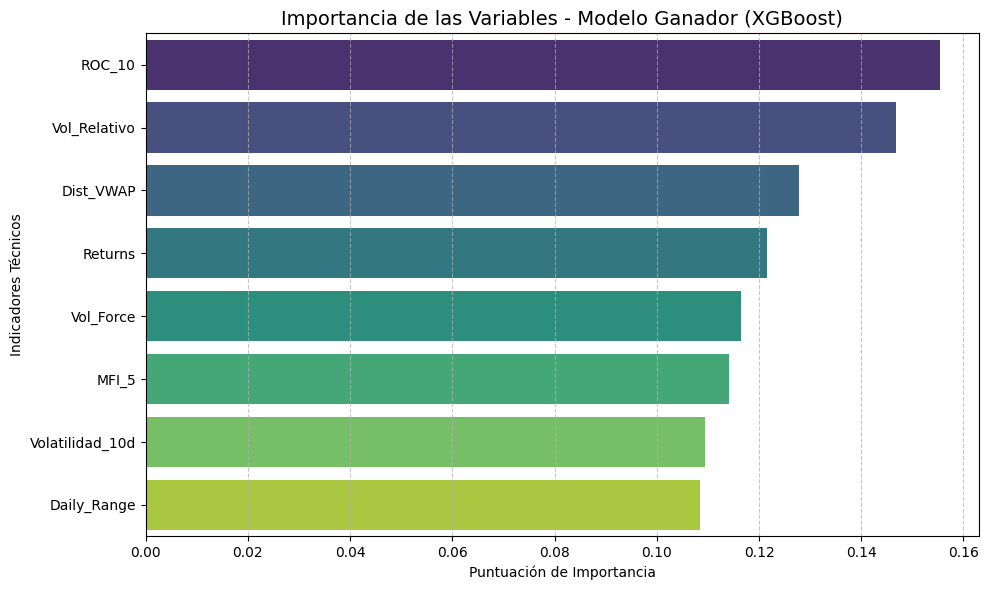

Las 3 variables clave son: ROC_10, Vol_Relativo, Dist_VWAP


In [65]:
# 1. Extraer las importancias del modelo ganador
importances = best_model.feature_importances_
feature_names = X_train.columns

# 2. Crear un DataFrame para facilitar la visualización
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.title(f'Importancia de las Variables - Modelo Ganador ({mejor_tipo})', fontsize=14)
plt.xlabel('Puntuación de Importancia')
plt.ylabel('Indicadores Técnicos')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Imprimir las 3 más importantes para tus notas
top_3 = feature_importance_df.head(3)['Feature'].tolist()
print(f"Las 3 variables clave son: {', '.join(top_3)}")

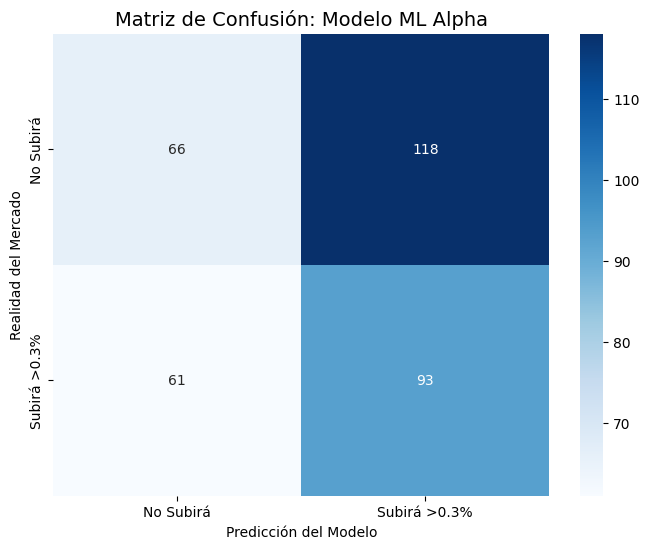

Precisión (Cuando el modelo dice 'Comprar', acierta el): 44.08%


In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Calcular la matriz con las predicciones filtradas
cm = confusion_matrix(y_test, y_pred_filtered)

# 2. Graficar de forma profesional
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Subirá', 'Subirá >0.3%'], 
            yticklabels=['No Subirá', 'Subirá >0.3%'])

plt.title('Matriz de Confusión: Modelo ML Alpha', fontsize=14)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad del Mercado')
plt.show()

# Extra: Imprimir métricas clave
precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
print(f"Precisión (Cuando el modelo dice 'Comprar', acierta el): {precision:.2%}")

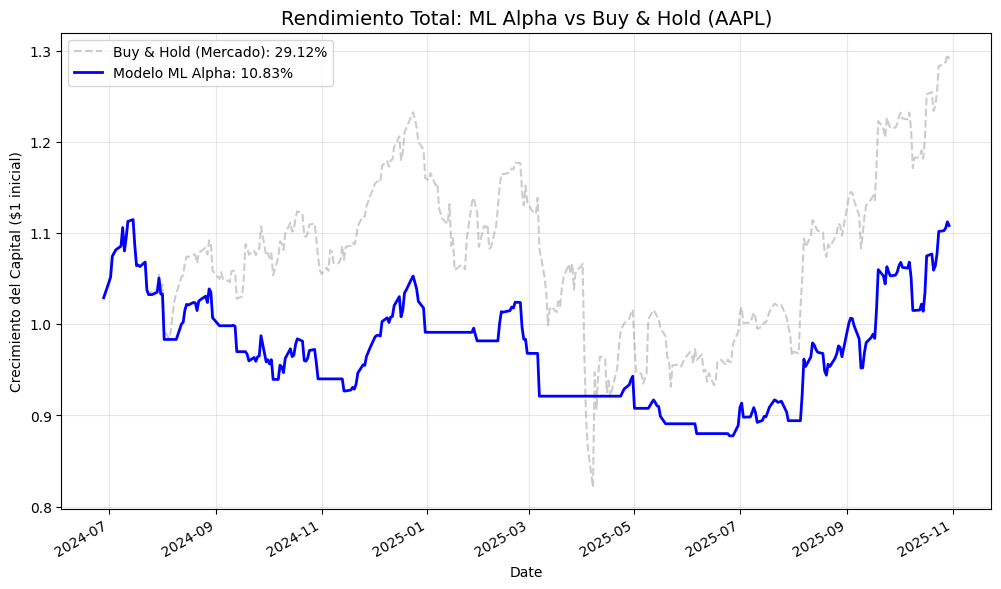

--- RESULTADOS FINALES ---
Rendimiento Total Buy & Hold: 29.12%
Rendimiento Total Estrategia ML: 10.83%
Diferencia (Alpha): -18.28%
Sharpe Ratio del Modelo: 0.52


In [67]:
# BACKTESTING Y VISUALIZACIÓN FINAL
# 1. Creamos la copia de trabajo
results = X_test.copy()

# 2. Sincronizamos retornos: la señal de hoy se aplica al retorno de MAÑANA
results['Next_Day_Return'] = data['Close'].pct_change().shift(-1).loc[X_test.index]
results['Strategy_Return'] = y_pred_filtered * results['Next_Day_Return']

# 3. Calculamos las series acumuladas eliminando el último valor nulo (NaN)
strategy_series = (1 + results['Strategy_Return']).dropna().cumprod()
market_series = (1 + results['Next_Day_Return']).dropna().cumprod()

# 4. Cálculo de Rendimientos Totales para comparar
rendimiento_estrategia = (strategy_series.iloc[-1] - 1) * 100
rendimiento_buy_hold = (market_series.iloc[-1] - 1) * 100

# 5. Cálculo del Sharpe Ratio (Métrica de eficiencia)
sharpe = (results['Strategy_Return'].mean() / results['Strategy_Return'].std()) * np.sqrt(252)

# --- Gráfico Comparativo ---
plt.figure(figsize=(12,7))
market_series.plot(label=f'Buy & Hold (Mercado): {rendimiento_buy_hold:.2f}%', color='gray', alpha=0.4, linestyle='--')
strategy_series.plot(label=f'Modelo ML Alpha: {rendimiento_estrategia:.2f}%', color='blue', linewidth=2)

plt.title(f'Rendimiento Total: ML Alpha vs Buy & Hold ({ticker})', fontsize=14)
plt.ylabel('Crecimiento del Capital ($1 inicial)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Consola de Resultados ---
print(f"--- RESULTADOS FINALES ---")
print(f"Rendimiento Total Buy & Hold: {rendimiento_buy_hold:.2f}%")
print(f"Rendimiento Total Estrategia ML: {rendimiento_estrategia:.2f}%")
print(f"Diferencia (Alpha): {rendimiento_estrategia - rendimiento_buy_hold:.2f}%")
print(f"Sharpe Ratio del Modelo: {sharpe:.2f}")